In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from scipy.ndimage import zoom
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import ast

import sys
sys.path.append("../")
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import nibabel as nb
import matplotlib.pyplot as plt
import functions_collection as ff
import Data_processing as dp

main_path = '/mnt/camca_NAS/Deepstrain/results'
patinet_info = pd.read_excel('/mnt/camca_NAS/SAM_for_CMR/data/Patient_list/HFpEF_fulldataset_basic_info_edited.xlsx')

### evaluate simple GLS first

In [71]:
from datetime import datetime
label_sheet = pd.read_excel('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/re-admission-info/HFpEF_readmission_list_finalized.xlsx')
label_list = []
for i in range(0, label_sheet.shape[0]):
    label = label_sheet.iloc[i, 1]
    if '0.5' in str(label):
        l = int(label[0])
    else:
        l = int(label)
    
    # readmission larger than one year
    if l == 1:
        readmission_date = int(label_sheet.iloc[i, 3])
        study_date = int(label_sheet.iloc[i]['StudyDate'])
       
        readmission_date = datetime.strptime(str(readmission_date), "%Y%m%d")
        study_date = datetime.strptime(str(study_date), "%Y%m%d")

        # calculate the time difference
        time_diff = (readmission_date - study_date).days
        if time_diff >= 366:
            print('readmission_date:', readmission_date, ' study_date:', study_date, ' time_diff:', time_diff)
            l = 1
    
    # count surgery
    if l == 0:
        surgery = label_sheet.iloc[i, 4]
        if surgery == 1:
            l = 1

    label_list.append(l)
label_list = np.asarray(label_list)

readmission_date: 2019-03-24 00:00:00  study_date: 2017-08-23 00:00:00  time_diff: 578
readmission_date: 2018-10-24 00:00:00  study_date: 2017-03-21 00:00:00  time_diff: 582
readmission_date: 2018-10-04 00:00:00  study_date: 2016-11-25 00:00:00  time_diff: 678
readmission_date: 2018-08-02 00:00:00  study_date: 2016-11-10 00:00:00  time_diff: 630
readmission_date: 2018-06-13 00:00:00  study_date: 2016-10-07 00:00:00  time_diff: 614
readmission_date: 2017-09-18 00:00:00  study_date: 2016-05-05 00:00:00  time_diff: 501
readmission_date: 2017-03-20 00:00:00  study_date: 2015-07-24 00:00:00  time_diff: 605
readmission_date: 2016-12-21 00:00:00  study_date: 2015-06-09 00:00:00  time_diff: 561
readmission_date: 2016-05-02 00:00:00  study_date: 2015-03-24 00:00:00  time_diff: 405


In [72]:
# GLS
gls_list = []
for i in range(0, label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    file = os.path.join(main_path, 'strain', patient_id, 'gls.npy')
    f = np.load(file)
    gls = f[-1]
    gls_list.append(gls)
gls_list = np.asarray(gls_list)

In [73]:
label_0_group = np.where(label_list == 0)[0]
label_1_group = np.where(label_list == 1)[0]
print('label 0:', len(label_0_group), ' label 1:', len(label_1_group))

gls_0 = gls_list[label_0_group]
gls_1 = gls_list[label_1_group]

# found out whether gls_0 is significantly different from gls_1
from scipy.stats import ttest_ind
t, p = ttest_ind(gls_0, gls_1)
print(t, p)

label 0: 94  label 1: 42
0.4063931209448106 0.6851020716835795


In [74]:
import numpy as np

def stratified_split(num_patients, label0_indices, label1_indices, num_groups=5):
    """
    Splits patients into groups while maintaining an even distribution of label 1 patients.
    
    Args:
    - num_patients (int): Total number of patients.
    - label0_indices (list): List of indices for label 0 patients.
    - label1_indices (list): List of indices for label 1 patients.
    - num_groups (int): Number of groups to split into. Default is 5.
    
    Returns:
    - groups (list of lists): A list containing each group, with patient indices for that group.
    """
    # Shuffle the indices for random distribution
    np.random.shuffle(label0_indices)
    np.random.shuffle(label1_indices)
    
    # Calculate the target number of label 1 patients per group
    target_label1_per_group = len(label1_indices) // num_groups
    
    # Initialize groups
    groups = [[] for _ in range(num_groups)]
    
    # Distribute label 1 patients across groups
    for i, idx in enumerate(label1_indices):
        groups[i % num_groups].append(idx)
    
    # Distribute label 0 patients across groups
    for i, idx in enumerate(label0_indices):
        groups[i % num_groups].append(idx)
    
    return groups

# Example usage
num_patients = 136
label0_indices = list(range(94))         # Example indices for label 0 patients
label1_indices = list(range(94, 136))    # Example indices for label 1 patients

# Get the split groups
groups = stratified_split(num_patients, label0_indices, label1_indices)

# Display the results
for i, group in enumerate(groups):
    print(f"Group {i + 1} (Total: {len(group)}, Label 1 Count: {sum(1 for x in group if x in label1_indices)}): {group}")


Group 1 (Total: 28, Label 1 Count: 9): [110, 112, 118, 123, 97, 134, 126, 111, 117, 75, 46, 53, 5, 26, 30, 29, 86, 39, 2, 33, 8, 68, 64, 54, 36, 72, 52, 76]
Group 2 (Total: 28, Label 1 Count: 9): [108, 105, 127, 113, 125, 114, 106, 95, 94, 45, 58, 20, 24, 77, 93, 88, 3, 17, 0, 92, 12, 22, 85, 37, 59, 83, 32, 89]
Group 3 (Total: 27, Label 1 Count: 8): [99, 120, 102, 131, 124, 96, 132, 133, 65, 19, 40, 51, 27, 38, 28, 79, 82, 56, 16, 14, 1, 49, 81, 42, 87, 11, 50]
Group 4 (Total: 27, Label 1 Count: 8): [109, 135, 100, 119, 107, 115, 128, 129, 41, 80, 61, 10, 67, 47, 7, 74, 15, 71, 25, 35, 69, 55, 66, 70, 57, 6, 43]
Group 5 (Total: 26, Label 1 Count: 8): [121, 130, 98, 104, 116, 101, 103, 122, 63, 91, 44, 48, 84, 34, 73, 60, 90, 62, 13, 9, 18, 4, 23, 31, 78, 21]


## now process the temporal strain

In [ ]:
# load the temporal strain and calculate the correlation matrix
patient_id = 'ID_0002'
folders = ff.sort_timeframe(ff.find_all_target_files(['tf_*'],os.path.join(main_path,'strain',patient_id)), 0,'_','')
Ecc_aha_ori = np.zeros((len(folders),16))
Err_aha_ori = np.zeros((len(folders),16))
for i in range(len(folders)):
    strain_file = np.load(os.path.join(main_path,'strain',patient_id,folders[i],'strain_info.npy'),allow_pickle=True)
    ecc_aha = np.asarray(strain_file[-2][:-1] )
    err_aha = np.asarray(strain_file[-1][:-1] )
    Ecc_aha_ori[i] = ecc_aha
    Err_aha_ori[i] = err_aha

Ecc_aha = np.zeros((16, len(folders))); Err_aha = np.zeros((16, len(folders)))
for i in range(0,16):
    for j in range(len(folders)):
        Ecc_aha[i,j] = Ecc_aha_ori[j,i]
        Err_aha[i,j] = Err_aha_ori[j,i

## load the temporal strain

In [91]:
def correlation_matrix_cal(patient_id):

    folders = ff.sort_timeframe(ff.find_all_target_files(['tf_*'],os.path.join(main_path,'strain',patient_id)), 0,'_','')
    Ecc_aha_ori = np.zeros((len(folders),16))
    Err_aha_ori = np.zeros((len(folders),16))
    for i in range(len(folders)):
        strain_file = np.load(os.path.join(main_path,'strain',patient_id,folders[i],'strain_info.npy'),allow_pickle=True)
        ecc_aha = np.asarray(strain_file[-2][:-1] )
        err_aha = np.asarray(strain_file[-1][:-1] )
        Ecc_aha_ori[i] = ecc_aha
        Err_aha_ori[i] = err_aha

    Ecc_aha = np.zeros((16, len(folders))); Err_aha = np.zeros((16, len(folders)))
    for i in range(0,16):
        for j in range(len(folders)):
            Ecc_aha[i,j] = Ecc_aha_ori[j,i]
            Err_aha[i,j] = Err_aha_ori[j,i]

    # sample 25 time frames
    row_in_info = patinet_info[patinet_info['patient_id'] == patient_id]
    t_original = ast.literal_eval(row_in_info['processed_time_frame_index_list'].values[0])
    t_original = [int(i) for i in t_original]; t_original = np.asarray(t_original)
    if t_original[0] !=0:
        tt = []
        for j in range(0, len(t_original)):
            a = t_original[j] - t_original[0]
            if a < 0:
                a = t_original[j] - t_original[0] + 25
            tt.append(a)
        t_original = np.asarray(tt)
            
    t_new = np.arange(0, 25)

    Ecc_aha_sample = np.zeros((16,25))
    Err_aha_sample = np.zeros((16,25))
    print(t_original, Ecc_aha.shape)

    for i in range(16):
        spl_ecc = make_interp_spline(t_original, Ecc_aha[i,:], k=2)  # k=3表示三次样条
        ecc_new = spl_ecc(t_new)

        spl_err = make_interp_spline(t_original, Err_aha[i,:], k=2)  # k=3表示三次样条
        err_new = spl_err(t_new)

        Ecc_aha_sample[i] = ecc_new
        Err_aha_sample[i] = err_new

    correlation_matrix_Ecc = np.corrcoef(Err_aha_sample)
    correlation_matrix_Err = np.corrcoef(Ecc_aha_sample)
    return correlation_matrix_Ecc, correlation_matrix_Err



In [92]:
for i in range(78, label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    
    
    print(i, patient_id)
        
    correlation_matrix_Ecc, correlation_matrix_Err = correlation_matrix_cal(patient_id)
    np.save(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Ecc.npy'), correlation_matrix_Ecc)
    np.save(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Err.npy'), correlation_matrix_Err)

77 ID_0932
[ 0  1  2  3  4  6  8 10 12 14 16 18 20 22 24] (16, 15)
78 ID_0809
[ 0  1  2  3  4  6  8 10 12 14 16 18 20 22 24] (16, 0)


ValueError: Shapes of x (15,) and y (0,) are incompatible

## Prepare for the ML

In [88]:
import numpy as np

def stratified_even_split(num_patients, label0_indices, label1_indices, num_groups=5):
    # Shuffle the indices for random distribution
    np.random.shuffle(label0_indices)
    np.random.shuffle(label1_indices)
    
    # Initialize empty groups
    groups = [[] for _ in range(num_groups)]
    
    # Distribute label 1 patients across groups evenly
    for i, idx in enumerate(label1_indices):
        groups[i % num_groups].append(idx)
    
    # Distribute label 0 patients across groups evenly
    for i, idx in enumerate(label0_indices):
        groups[i % num_groups].append(idx)
    
    # Balance total patient count in each group by redistributing if needed
    group_sizes = [len(group) for group in groups]
    while max(group_sizes) - min(group_sizes) > 1:
        # Find the group with the most patients and the group with the fewest
        max_group = group_sizes.index(max(group_sizes))
        min_group = group_sizes.index(min(group_sizes))
        
        # Move a patient from the largest group to the smallest group
        patient_to_move = groups[max_group].pop()
        groups[min_group].append(patient_to_move)
        
        # Recalculate group sizes
        group_sizes = [len(group) for group in groups]

    return groups


# Example usage
num_patients = 136
label0_indices = list(label_0_group)         # Example indices for label 0 patients
label1_indices = list(label_1_group)    # Example indices for label 1 patients

# Get the split groups
groups = stratified_even_split(num_patients, label0_indices, label1_indices)

# Display the results
for i, group in enumerate(groups):
    print(f"Group {i + 1} (Total: {len(group)}, Label 1 Count: {sum(1 for x in group if x in label1_indices)}): {group}")


Group 1 (Total: 27, Label 1 Count: 9): [36, 23, 63, 27, 95, 68, 0, 59, 61, 21, 31, 71, 132, 111, 108, 26, 105, 122, 22, 103, 98, 8, 72, 6, 109, 104, 14]
Group 2 (Total: 28, Label 1 Count: 9): [54, 69, 118, 43, 115, 29, 58, 57, 127, 11, 101, 50, 41, 16, 130, 9, 32, 96, 19, 94, 100, 97, 33, 3, 73, 80, 74, 13]
Group 3 (Total: 27, Label 1 Count: 8): [70, 5, 64, 12, 25, 123, 102, 7, 87, 40, 125, 135, 93, 84, 117, 119, 65, 62, 75, 49, 37, 48, 110, 60, 120, 106, 128]
Group 4 (Total: 27, Label 1 Count: 8): [17, 86, 79, 82, 66, 92, 2, 46, 10, 99, 45, 85, 113, 39, 15, 1, 114, 47, 55, 133, 28, 52, 83, 116, 34, 126, 42]
Group 5 (Total: 27, Label 1 Count: 8): [44, 121, 129, 18, 53, 30, 67, 78, 51, 81, 24, 107, 124, 90, 134, 35, 56, 131, 4, 89, 76, 20, 88, 77, 38, 112, 91]


In [63]:
from itertools import combinations

# Original list
numbers = list(range(16))  # [0, 1, 2, ..., 15]

# Generate all unique pairs
pairs = list(combinations(numbers, 2))


120


In [70]:
# flatten the correlation matrix
for i in range(0,1):# label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    correlation_matrix_Ecc = np.load(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Ecc.npy'))
    correlation_matrix_Err = np.load(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Err.npy'))
    
    correlation_matrix_Ecc_flat = []
    correlation_matrix_Err_flat = []
    for j in range(0, len(pairs)):
        pair = pairs[j]
        a = correlation_matrix_Ecc[pair[0], pair[1]]; correlation_matrix_Ecc_flat.append(a)
        b = correlation_matrix_Err[pair[0], pair[1]]; correlation_matrix_Err_flat.append(b)
    correlation_matrix_Ecc_flat = np.asarray(correlation_matrix_Ecc_flat)
    correlation_matrix_Err_flat = np.asarray(correlation_matrix_Err_flat) 

(120,) (120,)


## sample 25 time frames

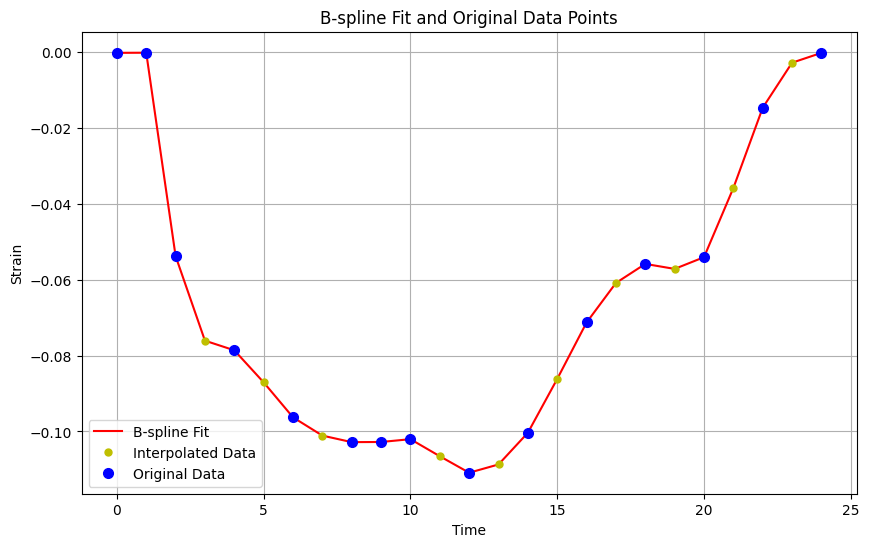

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import ast

# sample 25 time frames
row_in_info = patinet_info[patinet_info['patient_id'] == patient_id]
t_original = ast.literal_eval(row_in_info['processed_time_frame_index_list'].values[0])
t_original = [int(i) for i in t_original]; t_original = np.asarray(t_original)
t_new = np.arange(0, 25)

Ecc_aha_sample = np.zeros((16,25))
Err_aha_sample = np.zeros((16,25))


for i in range(16):
    spl_ecc = make_interp_spline(t_original, Ecc_aha[i,:], k=2)  # k=3表示三次样条
    ecc_new = spl_ecc(t_new)

    spl_err = make_interp_spline(t_original, Err_aha[i,:], k=2)  # k=3表示三次样条
    err_new = spl_err(t_new)

    Ecc_aha_sample[i] = ecc_new
    Err_aha_sample[i] = err_new


# # 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(t_new, Ecc_aha_sample[2,:], label='B-spline Fit', color='red')
plt.plot(t_new,Ecc_aha_sample[2,:], 'yo',markersize=5, label='Interpolated Data')
plt.plot(t_original, Ecc_aha[2,:], 'bo', markersize = 7,label='Original Data')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('B-spline Fit and Original Data Points')
plt.legend()
plt.grid(True)
plt.show()

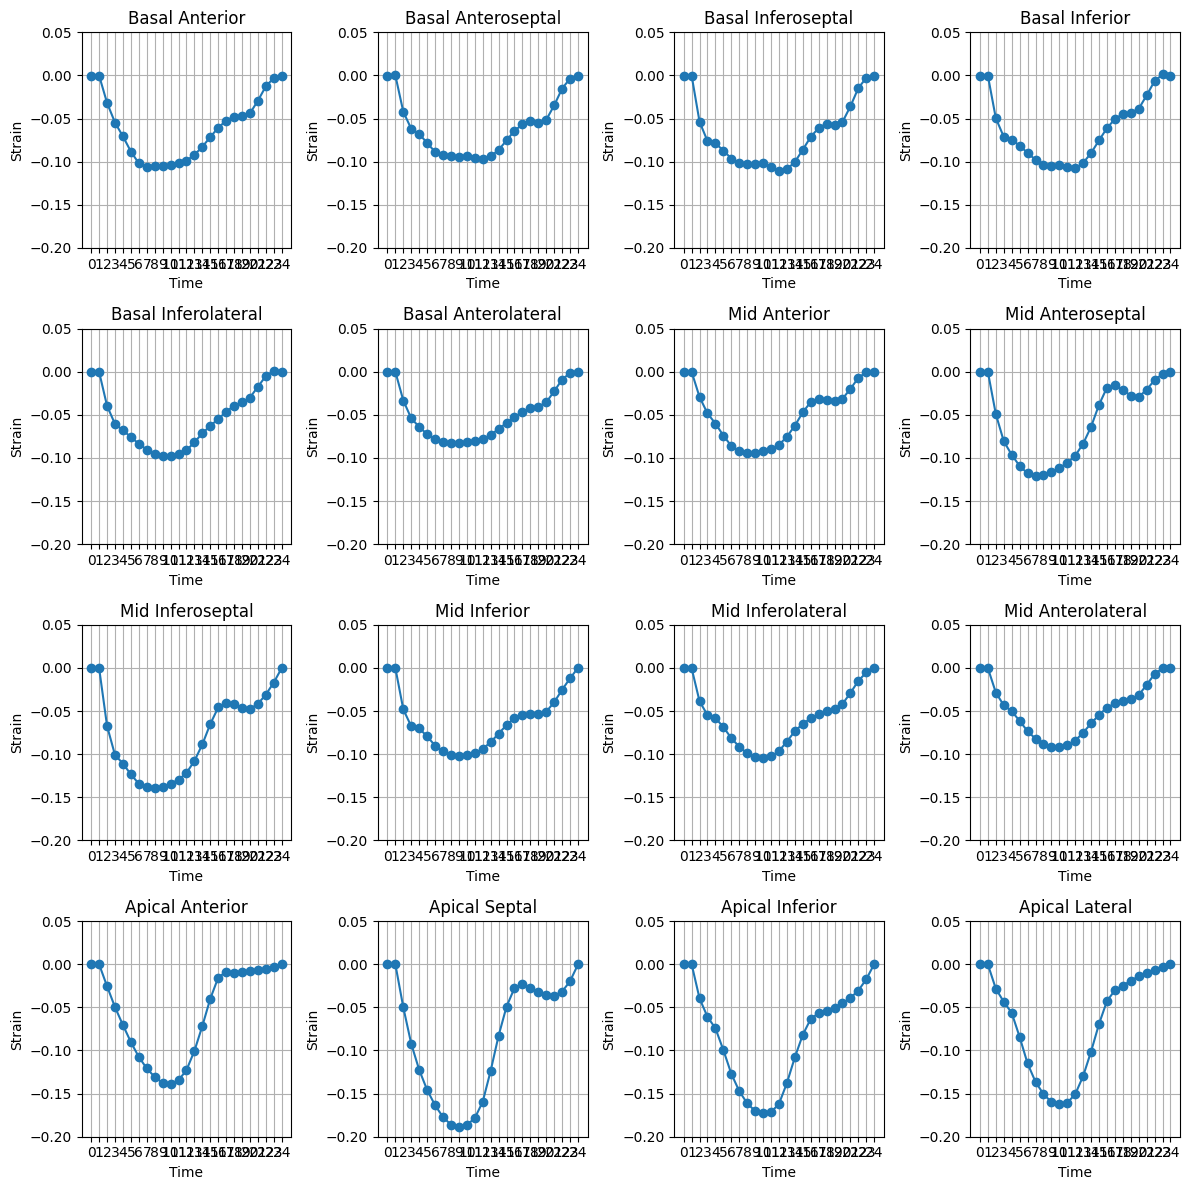

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your 16x15 array
# Each row represents a sample with 15 observations (strain values)
# Replace this with your actual data
# data = np.array([...])

# Example data for demonstration purposes (remove this when using your data)
# data = np.random.rand(16, 15)

data = Ecc_aha_sample

# Define the segment names for the AHA 16 segments
segment_names = [
    'Basal Anterior',
    'Basal Anteroseptal',
    'Basal Inferoseptal',
    'Basal Inferior',
    'Basal Inferolateral',
    'Basal Anterolateral',
    'Mid Anterior',
    'Mid Anteroseptal',
    'Mid Inferoseptal',
    'Mid Inferior',
    'Mid Inferolateral',
    'Mid Anterolateral',
    'Apical Anterior',
    'Apical Septal',
    'Apical Inferior',
    'Apical Lateral'
]

# Time points from 0 to 15 (total 16 points, but since your data has 15 observations, use 0 to 14)
time_points = np.arange(25)

# Create a 4x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    axes[i].plot(time_points, data[i, :], marker='o')
    axes[i].set_title(segment_names[i])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Strain')
    axes[i].grid(True)
    axes[i].set_ylim(-0.20, 0.05)
    axes[i].set_xticks(time_points,fontsize=4)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


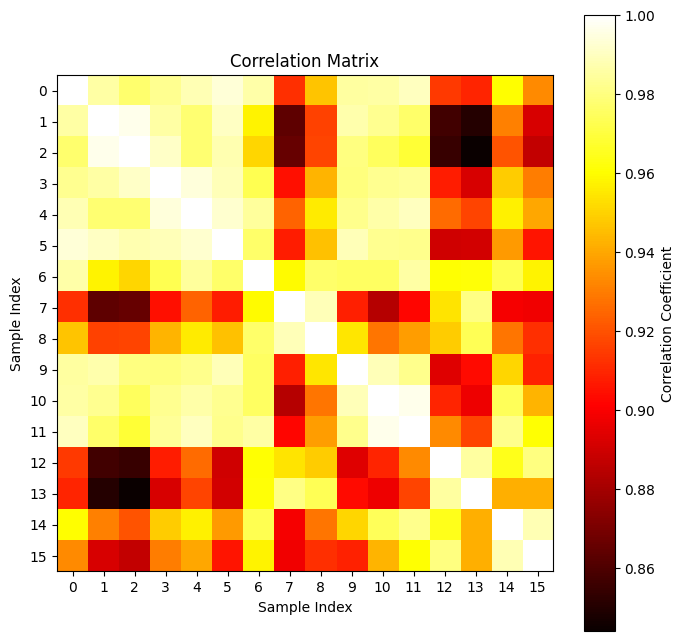

In [35]:
correlation_matrix = np.corrcoef(Ecc_aha_sample)
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.xticks(range(16))
plt.yticks(range(16))
plt.show()

In [36]:
correlation_matrix.shape

(16, 16)